# Assignment 1

[Dataset - Animal Image Dataset(DOG, CAT and PANDA)](https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
)

**NOTE:** THIS PROJECT IS DONE WITHIN AWS SAGEMAKER

**Dataset Details**:  
The dataset contains a total of 3000 images, 1000 for cats, 1000 for dogs and 1000 for pandas, each with their corresponding labels. The zip file containing these images is 'animals.zip'

### Part 1: Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

Doing this using Keras ImageDataGenerator

In [1]:
#Importing all required libraries
import numpy as np
from numpy import expand_dims

import pandas as pd

import os
from os import listdir

import cv2

from time import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


**mpimg** - To display image  
**expand_dims** - Expand the shape of the array  
**load_img** - To load image from destination  
**img_to_array** - For converting a loaded image in PIL format into a NumPy array  
**ImageDataGenerator** - technique that can be used to artificially expand the size of a training dataset, some functions: height shift & rotation  
**listdir** - used to get the list of all files and directories in the specified directory  
**Sequential** - Model being used with layers as Conv2D, MaxPooling2D, Dense, Dropout, Flatten  


In [2]:
#Initializing the path to dataset and the classes of the dataset
path = '/home/ec2-user/SageMaker/Data/'
animals = ['dogs', 'cats', 'panda']

In [3]:
#Initializing the ImageDataGenerator to augment the images as required

#For height shift:
datagen1 = ImageDataGenerator(height_shift_range=0.5)

#For rotation:
datagen2 = ImageDataGenerator(rotation_range=90)

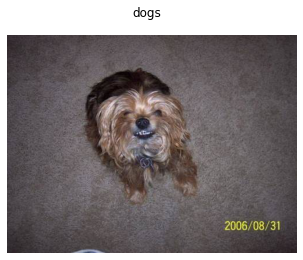

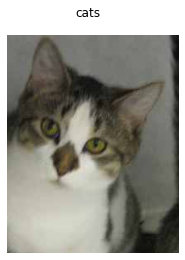

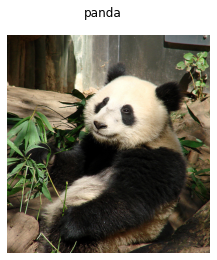

In [4]:
#To show original image

for category in animals:
    fig, _ = plt.subplots()
    fig.suptitle(category)
    fig.patch.set_facecolor('xkcd:white')
    for k, v in enumerate(os.listdir(path+category)[:1]):
        img = plt.imread(path+category+'/'+v)
        plt.subplot()
        plt.axis('off')
        plt.imshow(img)
    plt.show()

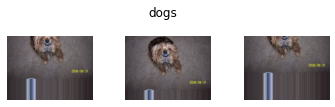

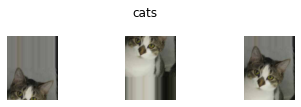

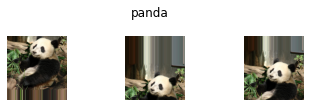

In [5]:
#For Height shift of above images

for category in animals:
    fig, _ = plt.subplots()
    fig.suptitle(category)
    fig.patch.set_facecolor('xkcd:white')
    for k,  v in enumerate(os.listdir(path+category)[:1]):
        img = plt.imread(path+category+'/'+v)
        arr = img_to_array(img)
        samples = expand_dims(arr, 0)
        it1 = datagen1.flow(samples, batch_size=1)
        for i in range(3):
            plt.subplot(330 + 1 + i)
            batch = it1.next()
            image = batch[0].astype('uint8')
            plt.axis('off')
            plt.imshow(image)
    plt.show()

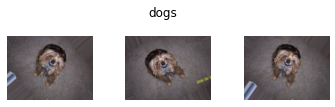

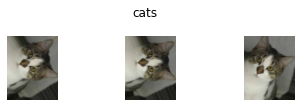

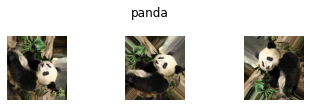

In [6]:
#For Rotation of above images

for category in animals:
    fig, _ = plt.subplots()
    fig.suptitle(category)
    fig.patch.set_facecolor('xkcd:white')
    for k,  v in enumerate(os.listdir(path+category)[:1]):
        img = plt.imread(path+category+'/'+v)
        arr = img_to_array(img)
        samples = expand_dims(arr, 0)
        it2 = datagen2.flow(samples, batch_size=1)
        for i in range(3):
            plt.subplot(330 + 1 + i)
            batch = it2.next()
            image = batch[0].astype('uint8')
            plt.axis('off')
            plt.imshow(image)
    plt.show()

***

### Part 2: Bring the train and test data in the required format & Print the shapes of train and test data.

Doing the splitting of the dataset into training and test (validation) using sklearn train_test_split since using ImageDataGenerator doesn't support viewing the images later.
  
Target size of the dataset = (108, 108, 3)  
Split : Test = 0.2


In [3]:
imagePaths = []
HEIGHT = 108
WIDTH = 108
N_CHANNELS = 3


In [4]:
for k, category in enumerate(animals):
    for f in os.listdir(path+category):
        imagePaths.append([path+category+'/'+f, k])

In [5]:
x = []
y = []

In [6]:
#Adding image and label to array form
for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (WIDTH, HEIGHT)) 
    x.append(image)
    label = imagePath[1]
    y.append(label)

In [7]:
#Resizing the values of pixxel so that they are in range 0-1
x = np.array(x, dtype="float") / 255.0
y = np.array(y)

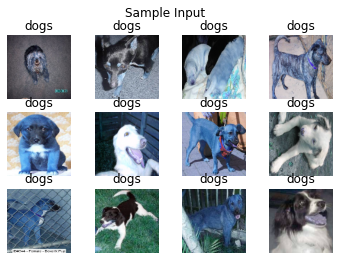

In [8]:
#To check if label and image have properly been appended to array
fig, _ = plt.subplots(3,4)
fig.suptitle("Sample Input")
fig.patch.set_facecolor('xkcd:white')
for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(animals[y[i]])
plt.show()

In [9]:
(Xtrain, Xtest, Ytrain, Ytest) = train_test_split(x, y, test_size=0.2)

In [10]:
Ytrain = to_categorical(Ytrain, 3)
Ytest = to_categorical(Ytest, 3)

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(2400, 108, 108, 3)
(600, 108, 108, 3)
(2400, 3)
(600, 3)


---

### Part 3: Defining the model


**Requirements:**
1. AT LEAST 3 hidden layers
2. L2 regularization to all the layers
3. One layer of dropout at the appropriate position
4. Appropriate activation function for all the layers
5. Compile the model with the appropriate loss function
6. Use an appropriate optimizer

1. Hidden layers:
  
The general way to make the layers is:  
  
**INPUT**  =>  ((**CONV** -> **RELU**)*N  =>  **POOL**)*M  =>  (**FC** -> **RELU**)*K  =>  **FC**  
  
Where,  
Conv = Concolution layer  
RELU = Activation  
FC = Fully connected layer (Dense layer)  
  
As an addition to this, a flatten layer as well as dropout layer is also used.  
Flatten - used to get a copy of an given array collapsed into one dimension.  
Dropout - randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.  



**Choosing the parameters:**
  
The input layer (that contains the image) should be divisible by 2 many times. Therefore, for the first conv layer, filters = 32 or 64.  
The conv layers should be using small filters (e.g. 3x3 or at most 5x5), using a stride of S=1.  
Therefore,  
Filter Size = 32 or 64; kernel_size = (2,2) or (3,3); stride = (1,1)  
  
The pool layers are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with 2x2 receptive fields, and with a stride of 2.  
Therefore,  
Pool layer - (2,2) with stride = 2  
  
The dropout layer should not be used at the end because the network has no ability to "correct" errors induced by dropout before the classification happens. Dropout can be used after convolutional layers and after pooling layers but is added after activation layer. Hence, I am placing the dropout layer following the second pool layer. Dropout rate 0.5 is used as default.  
  
**Final Layout of layers:**
1. Convolution Layer 
2. Pool layer 
3. Convolution Layer
4. Pool layer
5. Dropout layer
6. Flatten layer
7. Fully-Connected layer (Dense layer)
8. Dropout layer
9. Fully-Connected layer - units = 3 (Since output is between 3 classes)

**Activation**  
The activiation is provided as a parameter for while defining the layers. Among the many choice of activations, Relu is considered as the best. However, The softmax function is used as the activation function in the output layer of neural network models that predict a multinomial probability distribution as in the case of the animal classification. 

**Loss Function**  
The problem at hand required a multi-class classification and therefore, regression loss function and binary loss functions cannot be used. What is left is probablistic loss function. Among all available choices, it is recommended to use categorical_crossentropy for multi-class when the classes are mutually exclusive, as is in the current problem.

**Optimizer**  
Between all available optimizers, if one wants to train the neural network in less time and more efficiently than Adam is the optimizer. Hence, the optimizer being used is Adam - Adaptive Moment Estimation.

In [11]:
shape = (108, 108, 3)

In [12]:
model = Sequential()

model.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu', kernel_regularizer='l2',  input_shape=shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu', kernel_regularizer='l2'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(3, activation='softmax', kernel_regularizer='l2'))

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 107, 107, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

Since the dataset is relatively small with 2400 samples in total, I have used the standard batch size of 32


In [14]:
history = model.fit(Xtrain, Ytrain, validation_data = (Xtest, Ytest), batch_size=32, epochs=25, verbose=1)

Train on 2400 samples, validate on 600 samples
Epoch 1/25
2400/2400 [==============================] - 25s 10ms/step - loss: 1.8132 - accuracy: 0.5417 - val_loss: 1.2926 - val_accuracy: 0.5817
Epoch 2/25
2400/2400 [==============================] - 24s 10ms/step - loss: 1.1477 - accuracy: 0.6263 - val_loss: 1.1071 - val_accuracy: 0.5950
Epoch 3/25
2400/2400 [==============================] - 24s 10ms/step - loss: 1.0121 - accuracy: 0.6471 - val_loss: 0.9992 - val_accuracy: 0.6233
Epoch 4/25
2400/2400 [==============================] - 23s 10ms/step - loss: 0.9424 - accuracy: 0.6771 - val_loss: 0.9467 - val_accuracy: 0.6550
Epoch 5/25
2400/2400 [==============================] - 23s 10ms/step - loss: 0.9190 - accuracy: 0.6733 - val_loss: 0.9664 - val_accuracy: 0.6500
Epoch 6/25
2400/2400 [==============================] - 24s 10ms/step - loss: 0.9125 - accuracy: 0.6737 - val_loss: 0.9616 - val_accuracy: 0.6467
Epoch 7/25
2400/2400 [==============================] - 25s 11ms/step - loss:

AttributeError: 'builtin_function_or_method' object has no attribute 'time'

---

### Part 4: Model Evaluation

In [16]:
train_acc = history.history['accuracy'][24]
v_acc = history.history['val_accuracy'][24]
train_loss = history.history['loss'][24]
v_loss = history.history['val_loss'][24]

In [17]:
print('Final train loss = ', train_loss)
print('Final train accuracy = ', train_acc)
print('Final validation loss = ', v_loss)
print('Final validation loss = ', v_acc)

Final train loss =  0.7607371250788371
Final train accuracy =  0.76875
Final validation loss =  0.9111581707000732
Final validation loss =  0.6700000166893005


In [18]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [24]:
pred = model.predict(Xtest)
predictions = argmax(pred, axis=1)
y_true = argmax(Ytest, axis=1)

In [27]:
cm = confusion_matrix(y_true, predictions)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator


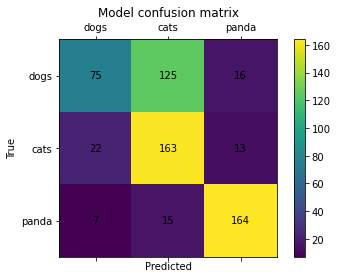

Accuracy : 67.00%


In [28]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + animals)
ax.set_yticklabels([''] + animals)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(y_true, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))

In [30]:
print(classification_report(y_true, predictions, target_names=animals))

              precision    recall  f1-score   support

        dogs       0.72      0.35      0.47       216
        cats       0.54      0.82      0.65       198
       panda       0.85      0.88      0.87       186

    accuracy                           0.67       600
   macro avg       0.70      0.68      0.66       600
weighted avg       0.70      0.67      0.65       600



Best performing class - Panda
Worst performing class - Dogs

---

### Part 5: Changing hyperparameters

#### 1. Dropout: Change the position and value of dropout layer

In [31]:
model1 = Sequential()

model1.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu', kernel_regularizer='l2',  input_shape=shape))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu', kernel_regularizer='l2'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model1.add(Dense(3, activation='softmax', kernel_regularizer='l2'))

In [32]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 107, 107, 64)      832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 52, 64)        16448     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 43264)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 43264)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [33]:
history1 = model1.fit(Xtrain, Ytrain, validation_data = (Xtest, Ytest), batch_size=32, epochs=25, verbose=1)

Train on 2400 samples, validate on 600 samples
Epoch 1/25
2400/2400 [==============================] - 25s 10ms/step - loss: 1.7300 - accuracy: 0.5067 - val_loss: 1.2570 - val_accuracy: 0.5567
Epoch 2/25
2400/2400 [==============================] - 24s 10ms/step - loss: 1.1147 - accuracy: 0.6112 - val_loss: 1.0466 - val_accuracy: 0.6000
Epoch 3/25
2400/2400 [==============================] - 24s 10ms/step - loss: 0.9793 - accuracy: 0.6438 - val_loss: 1.0017 - val_accuracy: 0.6150
Epoch 4/25
2400/2400 [==============================] - 24s 10ms/step - loss: 0.9376 - accuracy: 0.6517 - val_loss: 0.9937 - val_accuracy: 0.5867
Epoch 5/25
2400/2400 [==============================] - 25s 11ms/step - loss: 0.8988 - accuracy: 0.6633 - val_loss: 0.9652 - val_accuracy: 0.5783
Epoch 6/25
2400/2400 [==============================] - 24s 10ms/step - loss: 0.8794 - accuracy: 0.6667 - val_loss: 0.9440 - val_accuracy: 0.6367
Epoch 7/25
2400/2400 [==============================] - 24s 10ms/step - loss:

In [34]:
pred1 = model1.predict(Xtest)
predictions1 = argmax(pred1, axis=1)

In [35]:
cm1 = confusion_matrix(y_true, predictions1)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator


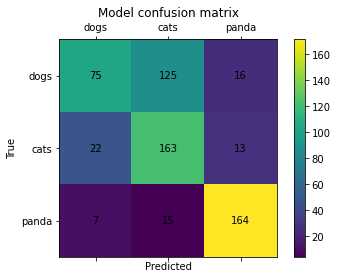

Accuracy : 66.00%


In [36]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_subplot(111)
cax = ax.matshow(cm1)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + animals)
ax.set_yticklabels([''] + animals)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy1 = accuracy_score(y_true, predictions1)
print("Accuracy : %.2f%%" % (accuracy1*100.0))

In [37]:
print(classification_report(y_true, predictions1, target_names=animals))

              precision    recall  f1-score   support

        dogs       0.64      0.48      0.54       216
        cats       0.57      0.62      0.59       198
       panda       0.76      0.92      0.83       186

    accuracy                           0.66       600
   macro avg       0.66      0.67      0.66       600
weighted avg       0.65      0.66      0.65       600



This model shows a slightly lower accuracy as compared to the easrlier model where the dropout layer was located preceeding the flatten layer and with a higher rate of 0.5 as compared to the rate of 0.3 given to this model.  
  
I assume the cause to be related to overfitting occuring as the dropout layer rate was reduced in this model.

#### 2. Regularization: Train a model without regularization

In [38]:
model2 = Sequential()

model2.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu',  input_shape=shape))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [39]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 107, 107, 64)      832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        16448     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43264)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 43264)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [40]:
model2.fit(Xtrain, Ytrain, validation_data = (Xtest, Ytest), batch_size=32, epochs=25, verbose=1)

Train on 2400 samples, validate on 600 samples
Epoch 1/25
2400/2400 [==============================] - 24s 10ms/step - loss: 0.8387 - accuracy: 0.5842 - val_loss: 0.7257 - val_accuracy: 0.6483
Epoch 2/25
2400/2400 [==============================] - 23s 10ms/step - loss: 0.6539 - accuracy: 0.6808 - val_loss: 0.7129 - val_accuracy: 0.6200
Epoch 3/25
2400/2400 [==============================] - 23s 10ms/step - loss: 0.5531 - accuracy: 0.7479 - val_loss: 0.6824 - val_accuracy: 0.6733
Epoch 4/25
2400/2400 [==============================] - 25s 10ms/step - loss: 0.4653 - accuracy: 0.7983 - val_loss: 0.7121 - val_accuracy: 0.6500
Epoch 5/25
2400/2400 [==============================] - 23s 10ms/step - loss: 0.3721 - accuracy: 0.8475 - val_loss: 0.7082 - val_accuracy: 0.6900
Epoch 6/25
2400/2400 [==============================] - 23s 10ms/step - loss: 0.3062 - accuracy: 0.8771 - val_loss: 0.8650 - val_accuracy: 0.6517
Epoch 7/25
2400/2400 [==============================] - 23s 10ms/step - loss:

In [41]:
pred2 = model2.predict(Xtest)
predictions2 = argmax(pred2, axis=1)

In [42]:
cm2 = confusion_matrix(y_true, predictions2)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator


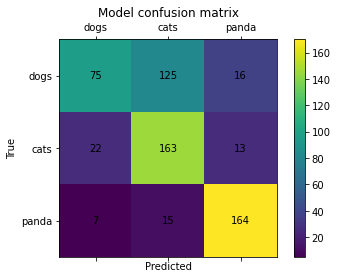

Accuracy : 68.83%


In [43]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_subplot(111)
cax = ax.matshow(cm2)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + animals)
ax.set_yticklabels([''] + animals)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy2 = accuracy_score(y_true, predictions2)
print("Accuracy : %.2f%%" % (accuracy2*100.0))

In [44]:
print(classification_report(y_true, predictions2, target_names=animals))

              precision    recall  f1-score   support

        dogs       0.76      0.45      0.56       216
        cats       0.61      0.74      0.67       198
       panda       0.73      0.91      0.81       186

    accuracy                           0.69       600
   macro avg       0.70      0.70      0.68       600
weighted avg       0.70      0.69      0.68       600



This model does appear to have a better accuracy of 68.83%, however looking at the accuracy accross training, it appears to be above 98%.  
This shows overfitting occuring across the training data. This is having less of an effect on the current test set since it is quite small, however for larger validation sets it would result in a much lower accuracy.  
The model using regularization is preferred.